# Week 5 Mini Project: Monet Style Image Generation with GAN

By: Jaeyoung Oh

Repo: https://github.com/BlueJayVRStudio/CSCA5642_Week5

## Problem Statement

This week we will be using GAN to generate Claude Monet style paintings from real photography. The purpose of a generative-adversarial network is to simultaneously train a network of data (visual images in our case) generator and a network of discriminator which distinguishes between real and fake inputs. The mini-max objective function aims to maximize a discriminator's ability to correctly identify real photos as real and fake photos as fake. In a typical GAN setup, we deal with a single domain of images for which we can feed in random noises to a generator to create fake images. However, this Kaggle competition requires us to convert images in one domain to those in another (real to monet style), so we will need a modified version of GAN such as conditional GAN or cycle GAN. For this project we will use CycleGAN as it fits our use case perfectly, and we will briefly explore why that is the case in the model building section. 

For our data, we have two sets of photos, real life photos (7038) and Monet photos (300), which contain images of 256x256px resolution with RGB color channels. Scoring on Kaggle is done using MiFID (Memorization-informed Fréchet Inception Distance), and it will not be implemented independently in this project. Furthermore, we must also consider that MiFID only measures how well a set of images mimic real images in a single particular domain, which means we do not have an objective measure of how well our output images mimic both of our image domains. Overall, however, we will still evaluate model convergence through loss metrics and review public Kaggle score as an approximate measure of our model performance.

Kaggle Competition/Data: https://www.kaggle.com/competitions/gan-getting-started

### Import Modules

In [2]:
import time
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow_examples.models.pix2pix.pix2pix import unet_generator, discriminator
from tensorflow.keras.utils import load_img, img_to_array

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

## EDA

In [18]:
def visualize_images_from_directory(directory, n_images=5):
    images = os.listdir(directory)
    sample_images = np.random.choice(images, n_images, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title(img_name)
    
    plt.tight_layout()
    plt.show()

def analyze_image_properties(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    print(f"Image size: {img.size} (width x height)")
    print(f"Image mode: {img.mode}")
    print(f"Array shape: {img_array.shape}")
    
    # display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    plt.show()
    
    # pixel intensity histogram
    if img_array.ndim == 2 or img_array.shape[2] == 1:
        plt.hist(img_array.ravel(), bins=50, color='gray')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            plt.hist(img_array[:, :, i].ravel(), bins=50, color=color, alpha=0.5, label=f'{color} channel')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

In [19]:
def clean_path(file):
    return os.path.basename(file)

def clean_ext(file):
    return file[:-4]

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


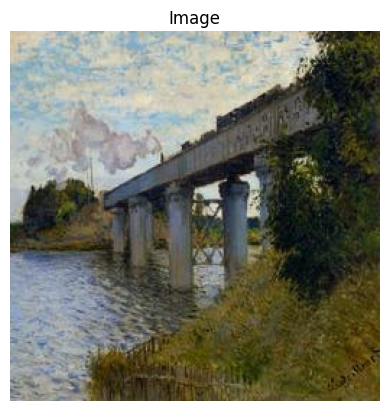

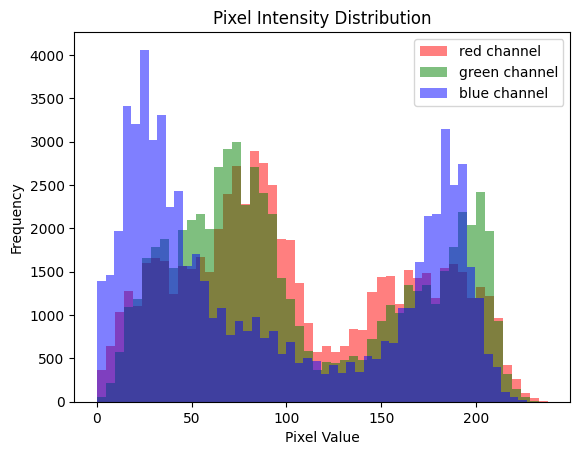

In [20]:
monet_image_path = "./data/monet_jpg/1a127acf4d.jpg"
analyze_image_properties(monet_image_path)

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


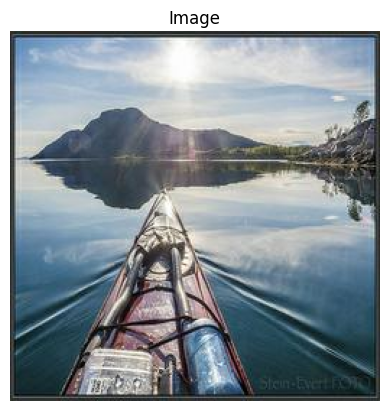

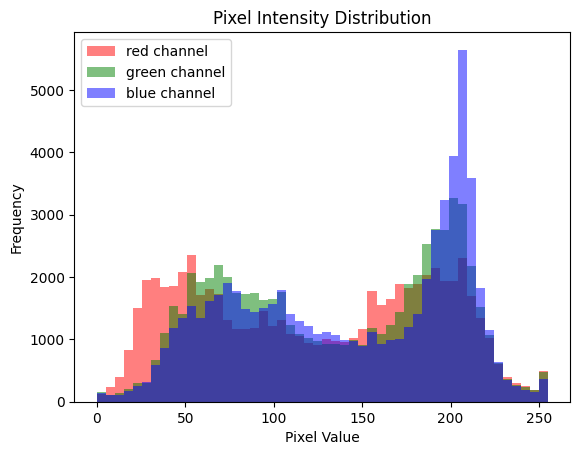

In [21]:
photo_image_path = "./data/photo_jpg/0a8839fac9.jpg"
analyze_image_properties(photo_image_path)

In [22]:
monet_path = './data/monet_jpg/'
photo_path = './data/photo_jpg/'

### Data Description

In [23]:
monet_paths = glob.glob('./data/monet_jpg/*.jpg')

monet_df = pd.DataFrame()

monet_df['file'] = monet_paths
monet_df['file_w_ext'] = monet_paths

monet_df['file'] = monet_df['file'].apply(clean_path).apply(clean_ext)
monet_df['file_w_ext'] = monet_df['file_w_ext'].apply(clean_path)

monet_df['label'] = 1
monet_df

file      file_w_ext  label
0    e3112413b1  e3112413b1.jpg      1
1    9d9a4fccfb  9d9a4fccfb.jpg      1
2    e291f8144f  e291f8144f.jpg      1
3    a210ceedc7  a210ceedc7.jpg      1
4    f84fb4516a  f84fb4516a.jpg      1
..          ...             ...    ...
295  61e735361a  61e735361a.jpg      1
296  f7836c88eb  f7836c88eb.jpg      1
297  68729aac07  68729aac07.jpg      1
298  2581464ddc  2581464ddc.jpg      1
299  05144e306f  05144e306f.jpg      1

[300 rows x 3 columns]

In [24]:
monet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        300 non-null    object
 1   file_w_ext  300 non-null    object
 2   label       300 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


In [25]:
photo_paths = glob.glob('./data/photo_jpg/*.jpg')

photo_df = pd.DataFrame()

photo_df['file'] = photo_paths
photo_df['file_w_ext'] = photo_paths

photo_df['file'] = photo_df['file'].apply(clean_path).apply(clean_ext)
photo_df['file_w_ext'] = photo_df['file_w_ext'].apply(clean_path)

photo_df['label'] = 1
photo_df

file      file_w_ext  label
0     b2633e0b11  b2633e0b11.jpg      1
1     e2cc5d0740  e2cc5d0740.jpg      1
2     9427fc76b9  9427fc76b9.jpg      1
3     f163b5185e  f163b5185e.jpg      1
4     eb33d8e41b  eb33d8e41b.jpg      1
...          ...             ...    ...
7033  d80d4c93de  d80d4c93de.jpg      1
7034  0df35db4a2  0df35db4a2.jpg      1
7035  25cb295b1f  25cb295b1f.jpg      1
7036  4a1bb1d46c  4a1bb1d46c.jpg      1
7037  36bcc9afa9  36bcc9afa9.jpg      1

[7038 rows x 3 columns]

In [26]:
photo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7038 entries, 0 to 7037
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        7038 non-null   object
 1   file_w_ext  7038 non-null   object
 2   label       7038 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 165.1+ KB


In [27]:
# paths to datasets
photo_dir = "./data/photo_jpg"
monet_dir = "./data/monet_jpg"

# create a list of file paths
photo_paths = [os.path.join(photo_dir, fname) for fname in os.listdir(photo_dir) if os.path.splitext(fname)[1] == '.jpg']
monet_paths = [os.path.join(monet_dir, fname) for fname in os.listdir(monet_dir) if os.path.splitext(fname)[1] == '.jpg']

In [28]:
_, file_extension = os.path.splitext(photo_paths[0])
print(_)
print(len(photo_paths), photo_paths[0], file_extension)

./data/photo_jpg/b2633e0b11
7038 ./data/photo_jpg/b2633e0b11.jpg .jpg


In [29]:
_, file_extension = os.path.splitext(monet_paths[0])
print(_)
print(len(monet_paths), monet_paths[0], file_extension)

./data/monet_jpg/e3112413b1
300 ./data/monet_jpg/e3112413b1.jpg .jpg


In [30]:
# define a preprocessing function
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [256, 256])  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# create tf.data.Dataset for each set
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_paths)
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_paths)

# apply preprocessing
photo_dataset = photo_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# batch and prefetch the datasets
photo_dataset = photo_dataset.batch(4).prefetch(tf.data.AUTOTUNE)

# we will have to repeat the monet images rather than truncating the real images 
# as the former has significantly fewer images. 
monet_dataset = monet_dataset.batch(4).prefetch(tf.data.AUTOTUNE).repeat()

combined_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

In [31]:
print(f"Confirm |combined dataset| = |photo dataset|:\n\
photo_dataset: {len(photo_dataset)}\n\
combined_dataset: {len(combined_dataset)}")

Confirm |combined dataset| = |photo dataset|:
photo_dataset: 1760
combined_dataset: 1760


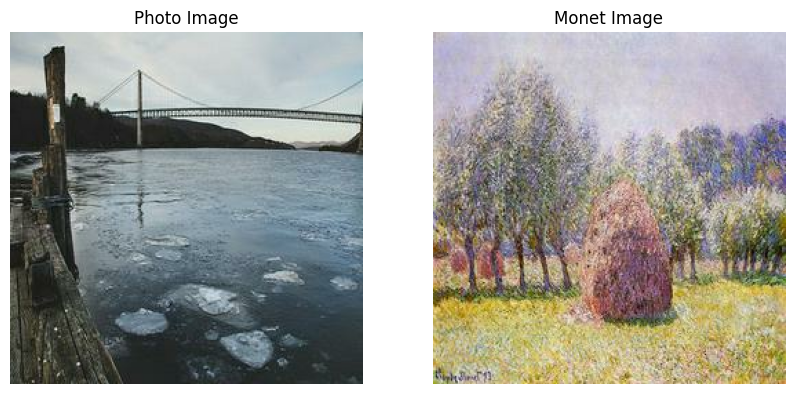

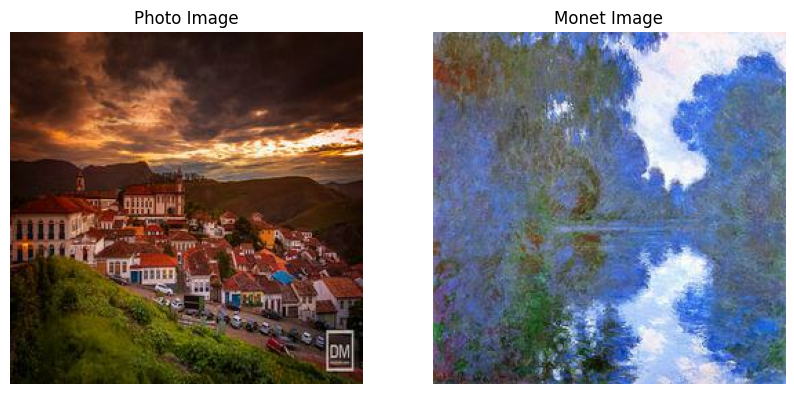

In [32]:
# confirm that the batches have been processed correctly
for photo_batch, monet_batch in combined_dataset.take(2):
    # select the first image from each batch
    photo_image = photo_batch[0].numpy()
    monet_image = monet_batch[0].numpy()

    # visualize real and Monet images
    plt.figure(figsize=(10, 5))

    # display real image
    plt.subplot(1, 2, 1)
    plt.title("Photo Image")
    plt.imshow(photo_image)
    plt.axis("off")

    # display the Monet image
    plt.subplot(1, 2, 2)
    plt.title("Monet Image")
    plt.imshow(monet_image)
    plt.axis("off")

    plt.show()

## EDA Conclusion

For this EDA section, we wrote a simple preprocessing function for loading our images and normalizing them between 0 and 1. As GAN is significantly more computationally expensive than CNN image classification, we opted not to include additional image augmentation. Lastly, we processed these images into tensorflow datasets and batched them into sets of 4 with the Monet dataset being repeated to match the size of the larger, real photo dataset.

## Model Building: CycleGAN

Reference: https://www.tensorflow.org/tutorials/generative/cyclegan

CycleGAN, as we mentioned in the introduction, is an ideal GAN architecture for working with two image domains. CycleGAN utilizes two generators and two discriminators which allows for an elegant solution for stylizing between two image classes. It still uses the same "mini-max" strategy as a normal GAN, but it adds two new loss functions called the cycle loss and identity loss. Take one generator G which maps domain X to domain Y and another generator F which maps the inverse, Y to X. The idea is to take F(G(X)) and ideally one would get back X since this operation describes going from X to Y then back to X. The difference between the original input X and the "cycled" X would serve as one of the loss metrics for training both of the generators. This loss is called the cycle loss, and we also include the reverse direction of G(F(Y)). Second, we have another metric called the identity loss. The motivation behind this is that, if one were to feed X into F, we should get back X, since X is already in the codomain of F. Similarly, if we were to feed Y into G, we should get back Y. With these two losses, cycle and identity loss, we have a well defined set of optimization constraints that allows for conversion between images in two different domains. In this project, we will implement this architecture and train it using the dataset from Kaggle.

In [45]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss



In [46]:
class CycleGAN_Model(tf.keras.Model):
    def __init__(self, gen_g, gen_f, disc_x, disc_y):
        super(CycleGAN_Model, self).__init__()
        self.generator_g = gen_g
        self.generator_f = gen_f
        self.discriminator_x = disc_x
        self.discriminator_y = disc_y

    def compile(self, generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
        super(CycleGAN_Model, self).compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer

    def train_step(self, train_generator):
        # persistent is set to True because the tape is used more than
        # once to calculate the gradients.

        real_x, real_y = train_generator
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X.
            # X: Real
            # Y: Monet
            
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)
            
            # same_x and same_y are used for identity loss.
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)
            
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)
            
            # calculate the loss
            gen_g_loss = generator_loss(disc_fake_y)
            gen_f_loss = generator_loss(disc_fake_x)
            
            total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
            
            # Total generator loss = adversarial loss + cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
            
            disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
            
        # Calculate the gradients for generator and discriminator
        generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            self.generator_f.trainable_variables)
        
        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                self.discriminator_y.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                self.generator_g.trainable_variables))
        
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                self.generator_f.trainable_variables))
        
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    self.discriminator_x.trainable_variables))
        
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    self.discriminator_y.trainable_variables))

        return {
            "gen_monet_loss": total_gen_g_loss,
            "gen_real_loss": total_gen_f_loss,
            "disc_monet_loss": disc_y_loss,
            "disc_real_loss": disc_x_loss,
        }

In [35]:
OUTPUT_CHANNELS=3

# instantiate unet generators and discriminators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [36]:
# generator.summary()

In [37]:
# compile the model
model = CycleGAN_Model(generator_g, generator_f, discriminator_x, discriminator_y)

In [38]:
model.summary()

Model: "cycle_gan__model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_15 (Functional)      │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_31 (Functional)      │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_35 (Functional)      │ (None, None, None, 1)  │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_39 (Functional)      │ (None, None, None, 1)  │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# train the model
# history = model.fit(combined_dataset_inv, steps_per_epoch=75, epochs=5)
# history = model.fit(combined_dataset_inv, epochs=1)

model.compile(
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='gen_monet_loss', patience=3, restore_best_weights=True, mode='min')
history = model.fit(combined_dataset, epochs=10, callbacks=[early_stopping])


Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 363s 154ms/step - disc_monet_loss: 0.6825 - disc_real_loss: 0.6639 - gen_monet_loss: 2.4586 - gen_real_loss: 2.5049
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 208s 118ms/step - disc_monet_loss: 0.6758 - disc_real_loss: 0.6533 - gen_monet_loss: 1.8582 - gen_real_loss: 1.9269
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 206s 117ms/step - disc_monet_loss: 0.6692 - disc_real_loss: 0.6570 - gen_monet_loss: 1.7366 - gen_real_loss: 1.7787
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 207s 117ms/step - disc_monet_loss: 0.5679 - disc_real_loss: 0.6533 - gen_monet_loss: 2.0314 - gen_real_loss: 1.7406
Epoch 5/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 206s 117ms/step - disc_monet_loss: 0.5054 - disc_real_loss: 0.6547 - gen_monet_loss: 2.2372 - gen_real_loss: 1.7312
Epoch 6/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 205s 117ms/step - disc_monet_loss: 0.4596 - disc_real_loss: 0.6561 - gen_monet_loss: 2.4544 - gen_real_loss: 1.7409
Epoch 7/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 206s 117ms

In [117]:
# generator_g.save('./models/generator_g.keras')
generator_g.save_weights('./models/generator_g.weights.h5')
# discriminator.save('./models/discriminator.keras')
# model.save('./models/model.keras')

In [39]:
# Plotting function
def plot_metrics(hist, name):
    gen_monet_loss_ = hist.history['gen_monet_loss']
    gen_real_loss_ = hist.history['gen_real_loss']
    disc_monet_loss_ = hist.history['disc_monet_loss']
    disc_real_loss_ = hist.history['disc_real_loss']

    plt.figure(figsize=(11, 7))

    plt.plot(range(len(gen_monet_loss_)), gen_monet_loss_, marker='o', label = 'generator loss (monet)')
    plt.plot(range(len(gen_monet_loss_)), gen_real_loss_, marker='o', label = 'generator loss (real)')
    plt.plot(range(len(gen_monet_loss_)), disc_monet_loss_, marker='o', label = 'discriminator loss (monet)')
    plt.plot(range(len(gen_monet_loss_)), disc_real_loss_, marker='o', label = 'discriminator loss (real)')
    
    plt.xticks(range(len(gen_monet_loss_)), range(len(gen_monet_loss_)), rotation=45)
    
    plt.legend() 
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(name)
    plt.grid(True)
    plt.show()

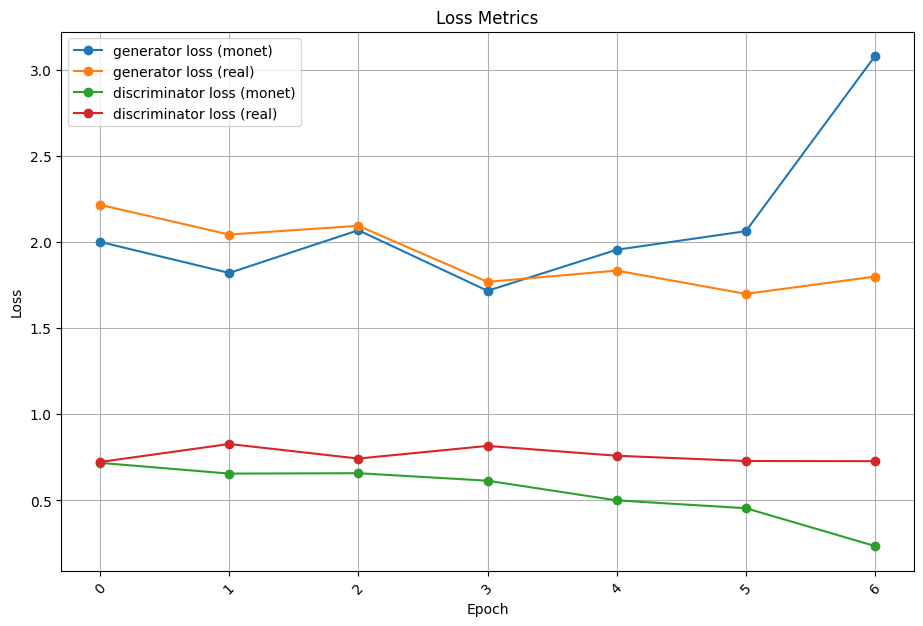

In [112]:
plot_metrics(history, "Loss Metrics")

In [40]:
# load and preprocess the input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# post-process the generated image
def postprocess_image(image_array):
    image_array = np.squeeze(image_array, axis=0)
    image_array = (image_array * 255).astype(np.uint8)
    return image_array

# predict a stylized image
def predict_image(image_path, _generator):
    input_image = preprocess_image(image_path)
    generated_image = _generator(input_image)
    return postprocess_image(generated_image)

# visualize the input and output
def visualize_predictions(image_dir, _generator, num_images=10):
    # get all image paths from the directory
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if os.path.splitext(fname)[1] == '.jpg']
    
    # randomly sample 10 images
    random_paths = random.sample(image_paths, num_images)
    
    # visualize predictions
    plt.figure(figsize=(15, num_images * 2.5))
    for i, image_path in enumerate(random_paths):
        # predict the stylized image
        generated_image = predict_image(image_path, _generator)
        # generated_image = np.expand_dims(generated_image, axis=0)
        # print(generated_image)
        
        # load the input image for visualization
        input_image = load_img(image_path, target_size=(256, 256))

        # display the input image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f"Input Image {i + 1}")
        plt.imshow(input_image)
        plt.axis("off")

        # display the stylized image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f"Stylized Image {i + 1}")
        plt.imshow(generated_image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

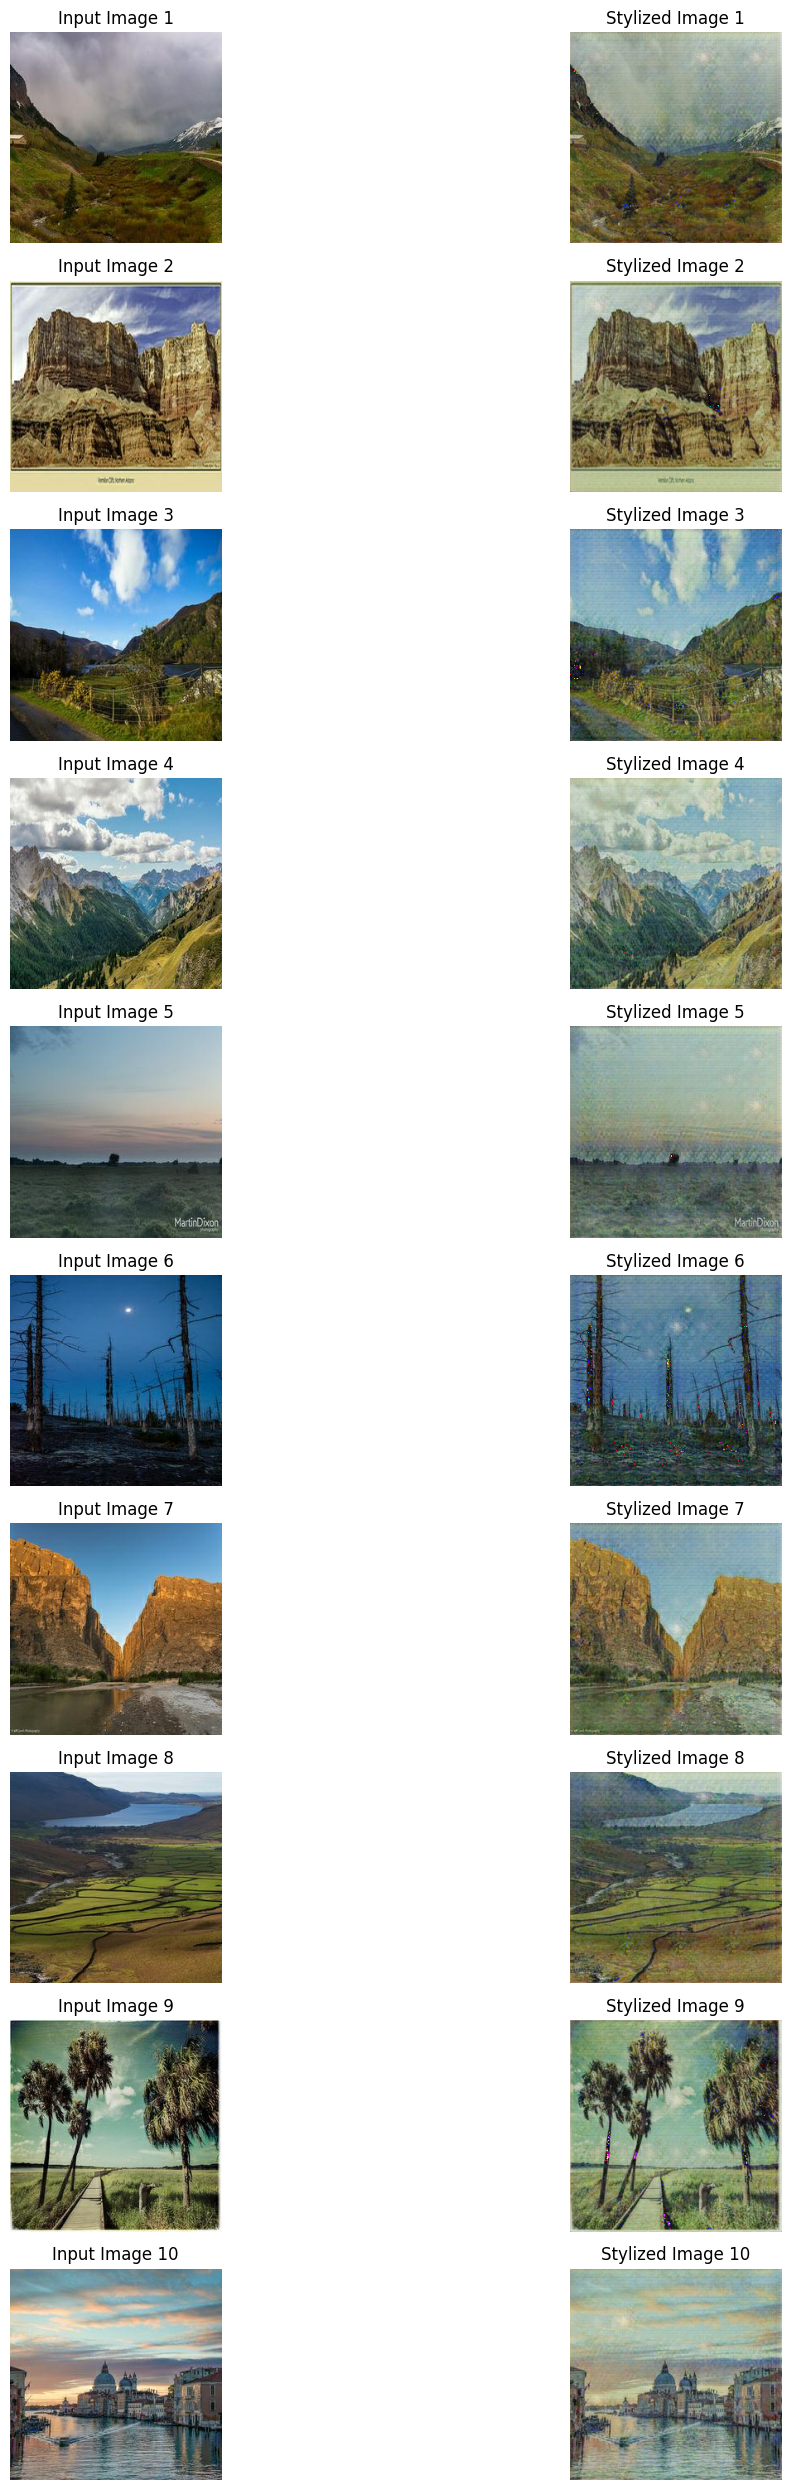

In [116]:
visualize_predictions("./data/photo_jpg", generator_g)

In [121]:
print('gen_monet_loss \n', history.history['gen_monet_loss'])
print('gen_real_loss \n', history.history['gen_real_loss'])
print('disc_monet_loss \n', history.history['disc_monet_loss'])
print('disc_real_loss \n', history.history['disc_real_loss'])

gen_monet_loss 
 [2.0000855922698975, 1.8196535110473633, 2.067734956741333, 1.7159878015518188, 1.9543811082839966, 2.062117576599121, 3.078352451324463]
gen_real_loss 
 [2.215036630630493, 2.0425734519958496, 2.093165159225464, 1.7679333686828613, 1.8333051204681396, 1.698227047920227, 1.7988206148147583]
disc_monet_loss 
 [0.717768669128418, 0.6553385257720947, 0.6575528383255005, 0.6140671968460083, 0.49994224309921265, 0.4545127749443054, 0.23491999506950378]
disc_real_loss 
 [0.7226359248161316, 0.8271307945251465, 0.742621123790741, 0.8160190582275391, 0.7589414119720459, 0.7284036874771118, 0.7274377346038818]


## Hyperparameter Tuning

In our results, we have determined that the Monet generator severely underperforms most likely because of the imbalance in the number of samples between Monet style images and Real images. Here we will use hyperparameter tuning to remedy some of that effect.

In [53]:
OUTPUT_CHANNELS=3

# instantiate unet generators and discriminators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [54]:
# instantiate model
model = CycleGAN_Model(generator_g, generator_f, discriminator_x, discriminator_y)

In [55]:
model.summary()

Model: "cycle_gan__model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_95 (Functional)      │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_111 (Functional)     │ (None, None, None, 3)  │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_115 (Functional)     │ (None, None, None, 1)  │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_119 (Functional)     │ (None, None, None, 1)  │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(
    tf.keras.optimizers.Adam(2e-2, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='gen_monet_loss', patience=3, restore_best_weights=True, mode='min')
history = model.fit(combined_dataset, epochs=10, callbacks=[early_stopping])

Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 442s 205ms/step - disc_monet_loss: 0.1054 - disc_real_loss: 0.6459 - gen_monet_loss: 12.0826 - gen_real_loss: 6.2283
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 295s 168ms/step - disc_monet_loss: 0.0091 - disc_real_loss: 0.6166 - gen_monet_loss: 14.5447 - gen_real_loss: 6.0466
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 298s 169ms/step - disc_monet_loss: 0.0544 - disc_real_loss: 0.5217 - gen_monet_loss: 12.3099 - gen_real_loss: 5.2948
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 297s 169ms/step - disc_monet_loss: 0.0011 - disc_real_loss: 0.4928 - gen_monet_loss: 12.8045 - gen_real_loss: 4.8708


In [58]:
generator_g.save_weights('./models/generator_g_tuned.weights.h5')

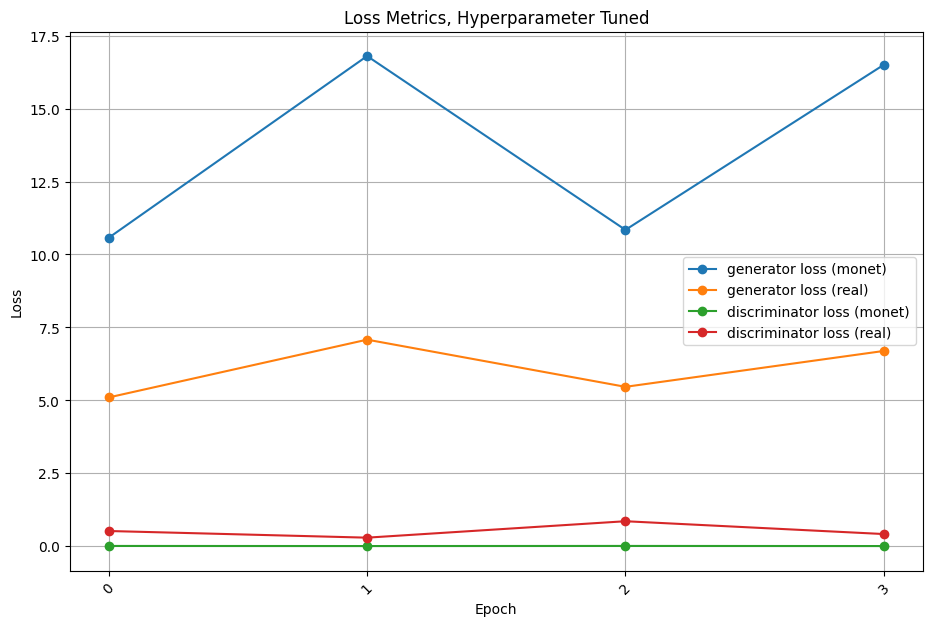

In [59]:
plot_metrics(history, "Loss Metrics, Hyperparameter Tuned")

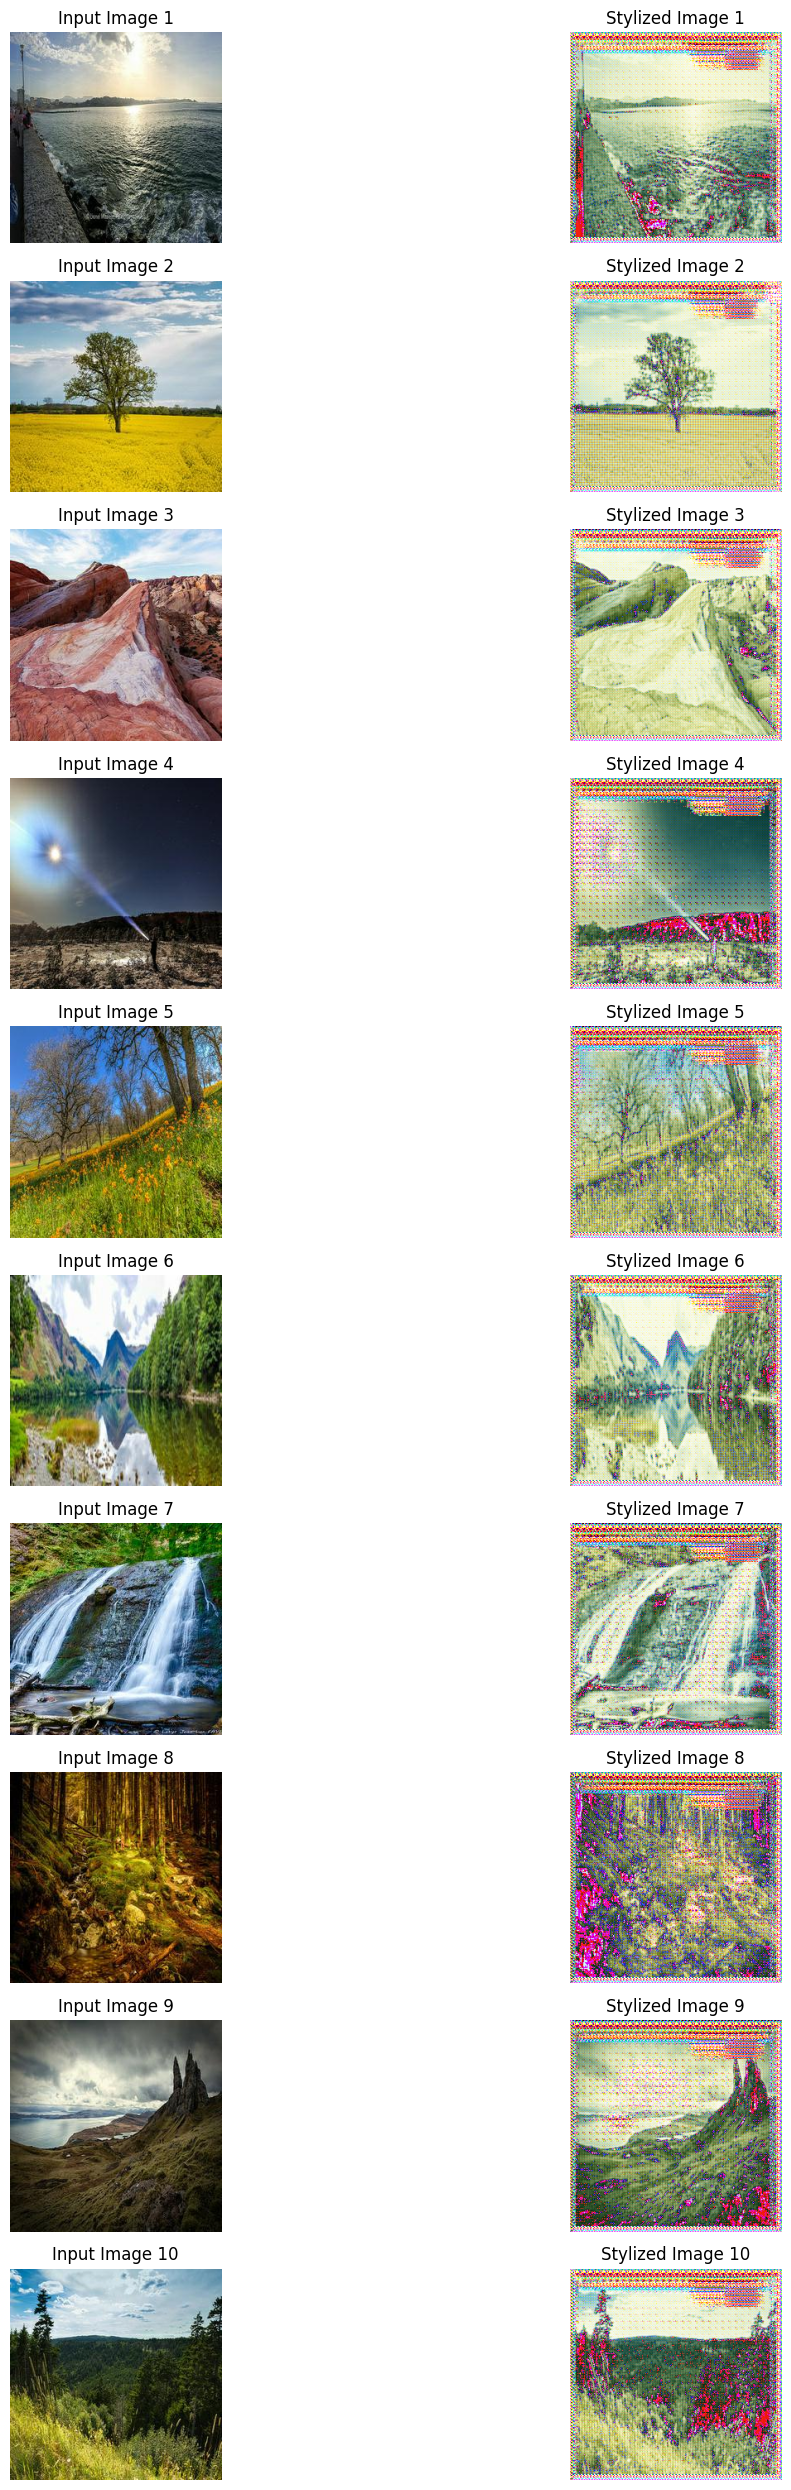

In [62]:
visualize_predictions("./data/photo_jpg", generator_g)

### Hyperparameter Tuning Conclusion:

For our hyperparameter tuning, we increased the learning rate of the Monet Generator (G). Although tuning this parameter was a promising path for increasing Monet generator performance, it did not yield a particularly good result. Because of the computational limitation we cannot iterate through lower learning rate for the discriminators as it will take significant amount of time to converge. However, this option is still valid but with greater resources and should be explored in the future. 

## Results and Analysis

|Epoch|Gen_Loss_Monet|Gen_Loss_Real|Disc_Loss_Monet|Disc_Loss_Real|
|-:|:-:|:-:|:-:|:-:|
|1|2.000|2.215|0.718|0.723|
|5|3.078|1.799|0.235|0.727|

<h5><center>Kaggle Public Score: 53.568</center></h5>

From our training, we observe a generally monotonic increase and decrease in our loss values. Monet Generator (G) loss increased from 2.000 to 3.078 and Real Generator (F) loss decreased from 2.215 to 1.799. Monet Discriminator loss decreased from 0.718 to 0.235 while Real Discriminator loss increased, most likely insignificantly, from 0.723 to 0.727.

#### Observations:
> Monet Generator (G) loss from 2.000 to 3.078; Monet Discriminator loss from 0.718 to 0.235:
> 
> - Here we observe a huge increase in loss for the Monet Generator yet a huge decrease in loss for Monet Discriminator. This suggests that the discriminator becomes very good at discerning fake Monet photos, possibly prematurely limiting the Monet Generator from improving
>
> Real Generator (F) loss from 2.215 to 1.799; Real Discriminator loss unchanged:
>
> - Real Generator loss decreases unlike that of the Monet Generator. The lack of significant change in the Real Discriminator loss suggests that it does indeed get better at discriminating fake real photos since it would have gained loss much more significantly had it not improved at all.

## Conclusion

MiFID score from Kaggle suggests that our model did achieve acceptable level of performance for generating Monet style painting, but there is a concerning increase in loss value for Monet Generator between the first and the last epochs. One explanation could be constructed from combined interpretation of our result. For instance, we observed that there was a significant improvement in real image generation while the opposite was true for Monet image generation. Furthermore, if we take the fact that there was more than an order of magnitude difference between the number of real photos and monet images, we can reach a reasonable conclusion that our monet generator overfit on the real images indirectly through cycle loss. One interesting future work based on this conclusion would be to artificially reduce the performance of function F through compression or to reduce the number of samples of real photos.

#### Future Work Suggestions:
1. Implement other GAN architectures 
> Before implementing CycleGAN I have explored a custom modified GAN architecture in which the generator takes in the real photos as input rather than random noise seed. The generator was optimized through the discriminator loss just like a regular GAN but with an added difference between the input and output. This led to a qualitatively better representation of Monet style imagery, but a worse depiction of the input real imagery. The kaggle public score using this model was approximately 90 which was unsatisfactory quantitatively, which led to the decision to use CycleGAN instead for detailed investigation for this mini project. However, the results were still significant and worth exploring in depth in the future.

2. Implement custom generators and discriminators
> In this project, I decided to use unet generator and discriminator from the tensorflow examples module. Although unet implementation uses sufficient number of downsampling and upsampling it doesn't use any dense layer which could help introduce interesting non-linearity. Additionally, by using dense layers between downsampling and upsampling, we would essentially be replicating an autoencoder architecture, which is known to capture latent spaces. This would certainly be an interesting line of experiments for future work.